In [1]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("./Apple/dataset_lookback_60_labelwindow_5.csv")

In [3]:
df

,Date,features,labels
0,1981-03-10,[0.09945 0.094261 0.087343 0.089504 0.092099 ...,Up
1,1981-03-11,[0.094261 0.087343 0.089504 0.092099 0.09772 ...,Up
2,1981-03-12,[0.087343 0.089504 0.092099 0.09772 0.102476 ...,Up
3,1981-03-13,[0.089504 0.092099 0.09772 0.102476 0.1068 ...,Up
4,1981-03-16,[0.092099 0.09772 0.102476 0.1068 0.112421 ...,Up
...,...,...,...
9526,2018-12-17,[52.11507 52.864506 53.199715 52.775913 53.86...,Down
9527,2018-12-18,[52.864506 53.199715 52.775913 53.860542 54.04...,Down
9528,2018-12-19,[53.199715 52.775913 53.860542 54.049706 54.41...,Down
9529,2018-12-20,[52.775913 53.860542 54.049706 54.413639 54.89...,Down


In [4]:
df['labels'].value_counts()

Up      5051
Down    4480
Name: labels, dtype: int64

In [15]:
Date = df['Date'][1:2]
print(Date)

# Load the Data
# closing_prices = df['features'][1:2].values
closing_prices = df['features'][7].replace('[', '').replace(']', '').replace('\n', '').split()
closing_prices = [float(val) for val in closing_prices]

closing_prices = np.array(closing_prices)
print(closing_prices)

def wavelet_denoising(data, wavelet='db4', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # Estimating the threshold using Stein's Unbiased Risk Estimate
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Apply soft thresholding
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    # Reconstruct the signal
    denoised_data = pywt.waverec(coeffs, wavelet)
    return denoised_data

denoised_prices = wavelet_denoising(closing_prices)


1    1981-03-11
Name: Date, dtype: object
[0.1068   0.112421 0.122799 0.124528 0.121502 0.118043 0.11934  0.116746
 0.111556 0.1068   0.104639 0.110259 0.109395 0.105503 0.105936 0.108098
 0.107233 0.113718 0.110259 0.112421 0.113718 0.113286 0.111556 0.110692
 0.107233 0.103342 0.09772  0.092099 0.095558 0.099017 0.099017 0.09945
 0.094261 0.094261 0.091235 0.090369 0.088207 0.090369 0.094261 0.08864
 0.083884 0.085181 0.082154 0.087343 0.08864  0.091667 0.092099 0.090802
 0.089937 0.089504 0.08864  0.081722 0.07783  0.074803 0.07783  0.076965
 0.079992 0.083884 0.089072 0.088207]


/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


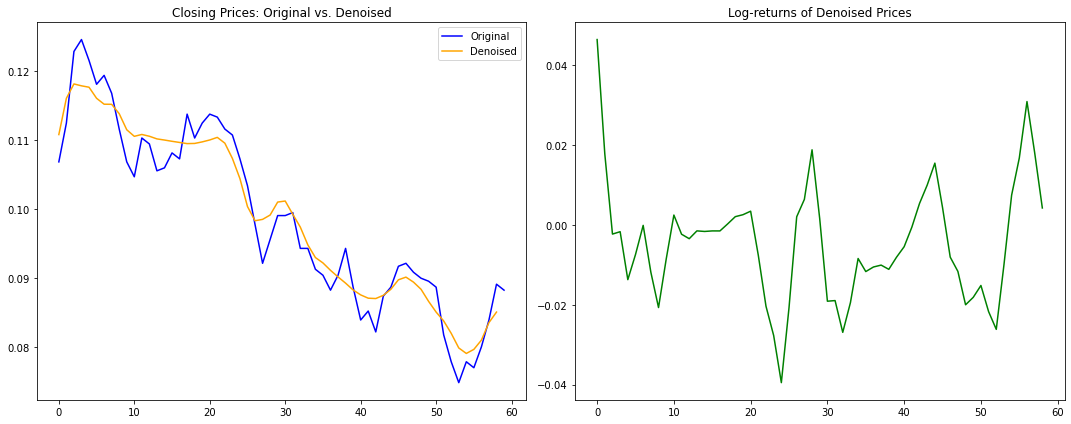

In [16]:
# Calculate log-returns
log_returns = np.diff(np.log(denoised_prices))

# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(closing_prices, label="Original", color='blue')
plt.plot(denoised_prices[:-1], label="Denoised", color='orange')
plt.legend()
plt.title('Closing Prices: Original vs. Denoised')

plt.subplot(1, 2, 2)
plt.plot(log_returns, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()


# plt.figure(figsize=(14, 7))
# plt.plot(closing_prices, label='Original Signal', color='blue')
# plt.plot(denoised_prices, label='Denoised Signal', color='orange')
# plt.legend()
# plt.title('Stock Price Denoising using DWT')
# plt.xlabel('Days')
# plt.ylabel('Closing Price')
# plt.show()


/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


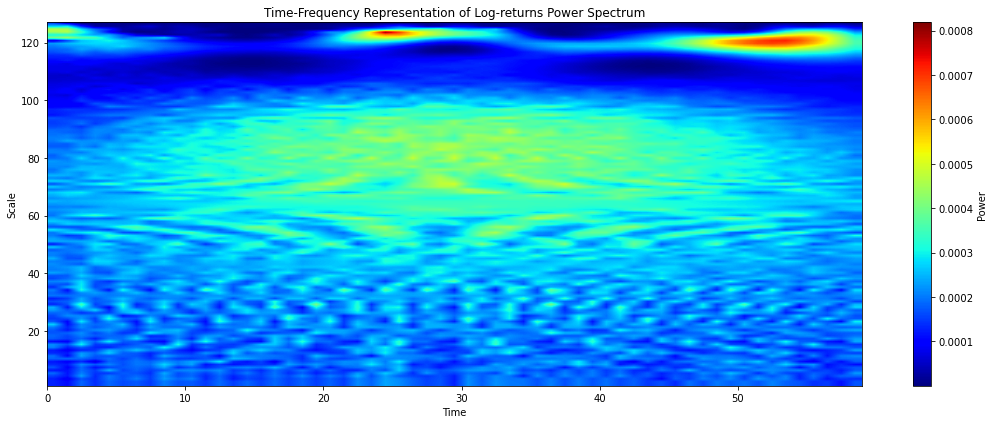

In [17]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()

In [18]:
# Define the Morlet wavelet, though note that the 'cmor' wavelet provided by pywt is a complex Morlet wavelet
widths = np.arange(1, 51)  # Define the range of scales to analyze
cwt_coeffs, frequencies = pywt.cwt(denoised_prices, widths, 'cmor')


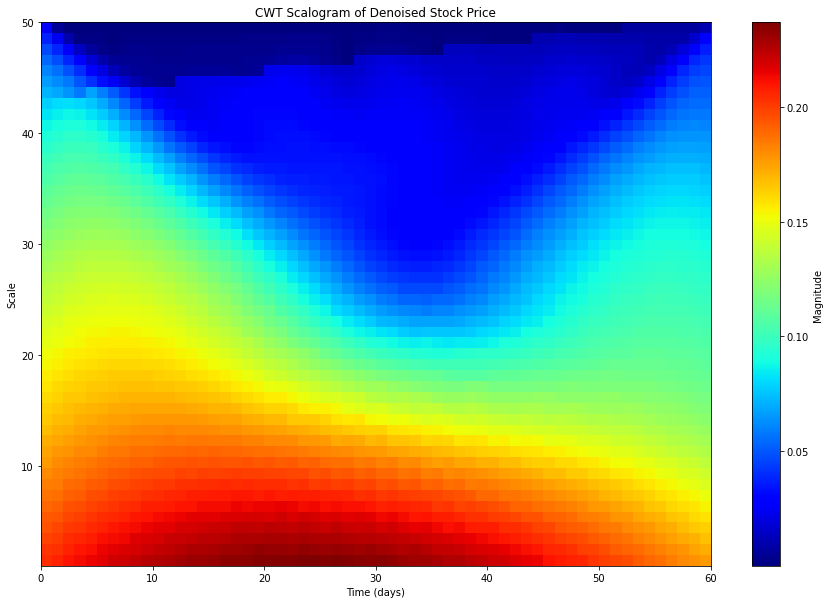

In [19]:
plt.figure(figsize=(15, 10))
plt.imshow(np.abs(cwt_coeffs), aspect='auto', extent=[0, len(denoised_prices), 1, 50], cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Time (days)')
plt.title('CWT Scalogram of Denoised Stock Price')
plt.show()


In [48]:
closing_prices

array([0.1068  , 0.112421, 0.122799, 0.124528, 0.121502, 0.118043,
       0.11934 , 0.116746, 0.111556, 0.1068  , 0.104639, 0.110259,
       0.109395, 0.105503, 0.105936, 0.108098, 0.107233, 0.113718,
       0.110259, 0.112421, 0.113718, 0.113286, 0.111556, 0.110692,
       0.107233, 0.103342, 0.09772 , 0.092099, 0.095558, 0.099017,
       0.099017, 0.09945 , 0.094261, 0.094261, 0.091235, 0.090369,
       0.088207, 0.090369, 0.094261, 0.08864 , 0.083884, 0.085181,
       0.082154, 0.087343, 0.08864 , 0.091667, 0.092099, 0.090802,
       0.089937, 0.089504, 0.08864 , 0.081722, 0.07783 , 0.074803,
       0.07783 , 0.076965, 0.079992, 0.083884, 0.089072, 0.088207])

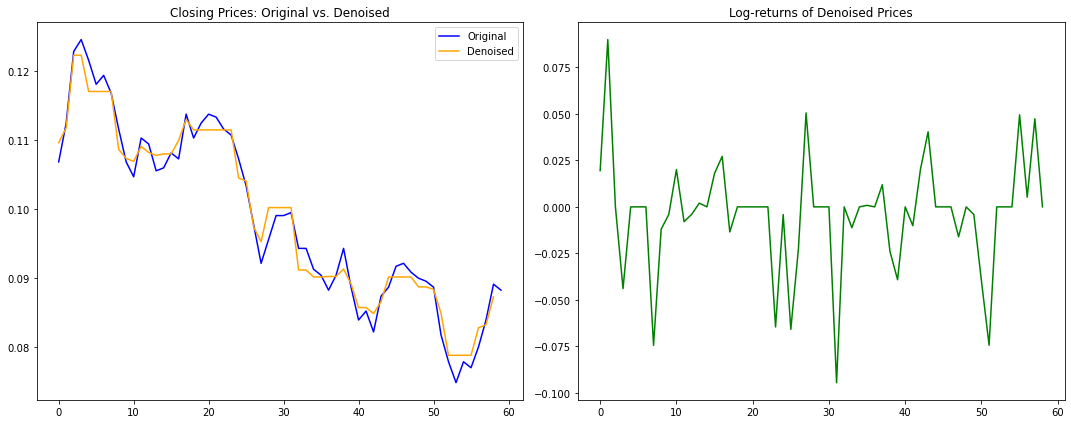

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
# import pandas_datareader.data as web



# Wavelet Decomposition
coeffs = pywt.wavedec(closing_prices, 'db1')

# Denoising: Thresholding the coefficients
# Setting all coefficients below a threshold to zero
threshold = 0.5 * np.max(coeffs[-1])
coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

# Reconstruct the denoised signal
denoised_prices = pywt.waverec(coeffs, 'db1')

# Calculate log-returns
log_returns = np.diff(np.log(denoised_prices))

# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(closing_prices, label="Original", color='blue')
plt.plot(denoised_prices[:-1], label="Denoised", color='orange')
plt.legend()
plt.title('Closing Prices: Original vs. Denoised')

plt.subplot(1, 2, 2)
plt.plot(log_returns, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()


/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


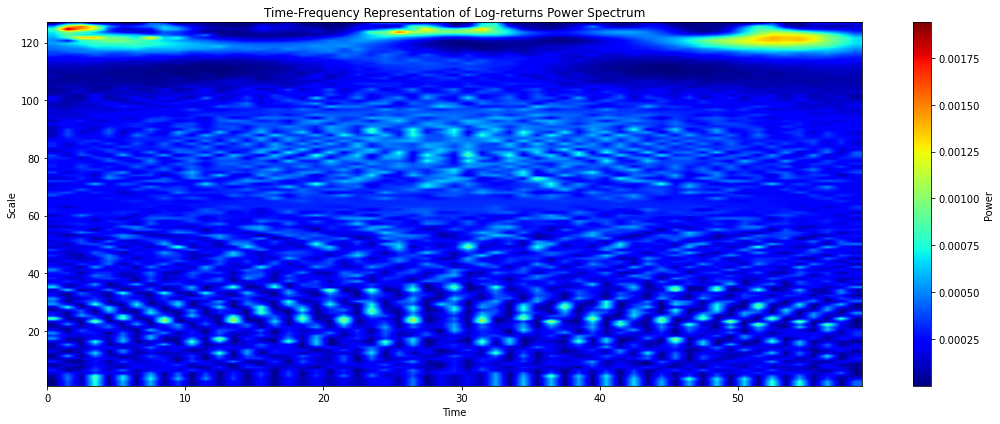

In [21]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()

/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


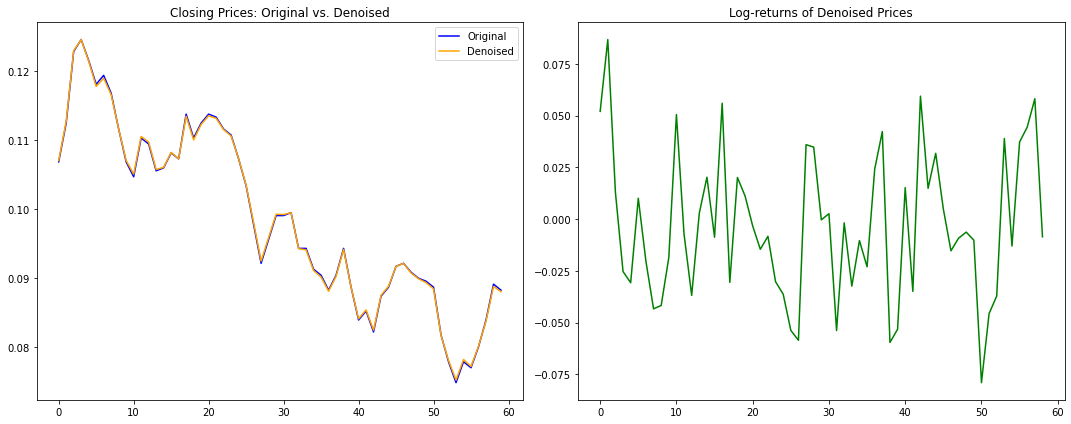

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
# import pandas_datareader.data as web

# For this example, I will use some dummy data. You should replace this with your actual closing_prices.
# e.g., closing_prices = df['Close'] if you're using yfinance to fetch stock price data.
# closing_prices = np.cumsum(np.random.randn(500) + 0.5)

def rigrsure_threshold(data):
    n = len(data)
    sort_sq = np.sort(data**2)
    risk_j = (np.arange(n) + 2 * (n - np.arange(n)) * sort_sq + (1 / (n ** 2)) * ((n - np.arange(n)) ** 2) * sort_sq.cumsum())
    return np.sqrt(sort_sq[np.argmin(risk_j)])

# Wavelet Decomposition to level 5 using 'db4' wavelet
coeffs = pywt.wavedec(closing_prices, 'db4', level=5)

# Denoising: Thresholding the coefficients using 'rigrsure' method
coeffs[1:] = [pywt.threshold(c, value=rigrsure_threshold(c), mode='soft') for c in coeffs[1:]]

# Reconstruct the denoised signal
denoised_prices = pywt.waverec(coeffs, 'db4')

# Make sure the length is consistent with the original signal after reconstruction
if denoised_prices.size != closing_prices.size:
    denoised_prices = denoised_prices[:closing_prices.size]

# Calculate log-returns
log_returns_1 = np.diff(np.log(denoised_prices))

# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(closing_prices, label="Original", color='blue')
plt.plot(denoised_prices, label="Denoised", color='orange')
plt.legend()
plt.title('Closing Prices: Original vs. Denoised')

plt.subplot(1, 2, 2)
plt.plot(log_returns_1, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()


/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


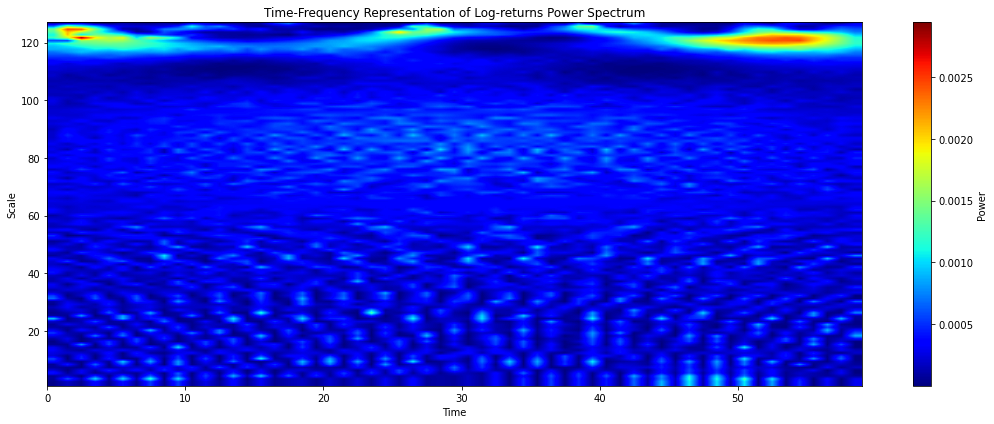

In [32]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns_1, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()

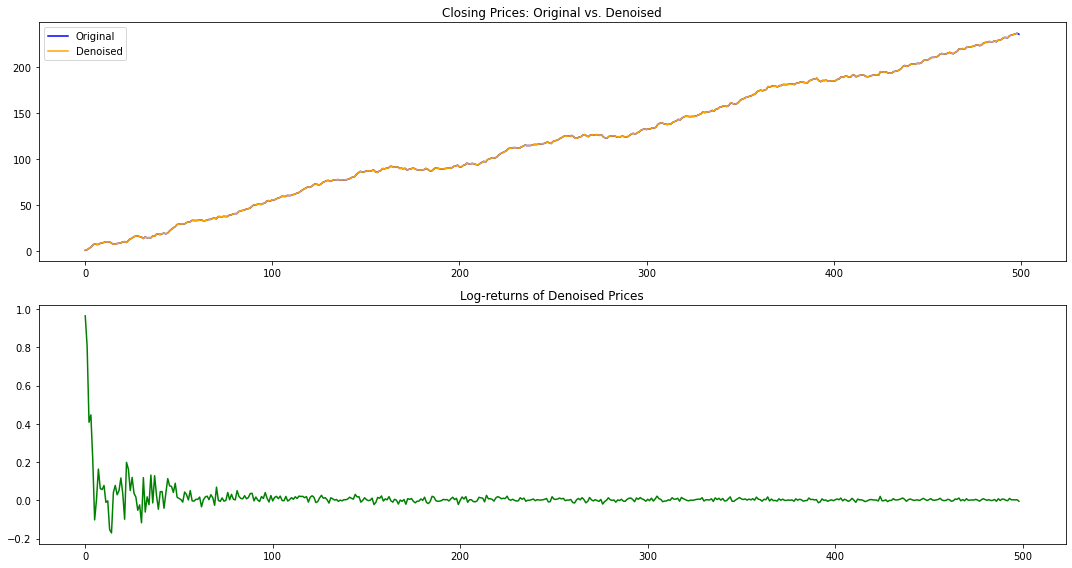

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Sample data
# closing_prices = np.cumsum(np.random.randn(500) + 0.5)

def rigrsure_threshold(data):
    n = len(data)
    sort_sq = np.sort(data**2)
    risk_j = (np.arange(n) + 2 * (n - np.arange(n)) * sort_sq + (1 / (n ** 2)) * ((n - np.arange(n)) ** 2) * sort_sq.cumsum())
    return np.sqrt(sort_sq[np.argmin(risk_j)])

# DWT using 'db4' wavelet up to level 5
coeffs = pywt.wavedec(closing_prices, 'db4', level=5)

# Thresholding coefficients using rigrsure
coeffs[1:] = [pywt.threshold(c, value=rigrsure_threshold(c), mode='soft') for c in coeffs[1:]]

# Reconstructing denoised signal
denoised_prices = pywt.waverec(coeffs, 'db4')

# Calculate log-returns
log_returns = np.diff(np.log(denoised_prices))

# Visualization
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(closing_prices, label="Original", color='blue')
plt.plot(denoised_prices[:-1], label="Denoised", color='orange')
plt.legend()
plt.title('Closing Prices: Original vs. Denoised')

plt.subplot(2, 1, 2)
plt.plot(log_returns, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()


In [ ]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Assuming closing_prices is a pandas series containing the closing prices of the stock

def rigrsure_threshold(data):
    n = len(data)
    sort_sq = np.sort(data**2)
    risk_j = (np.arange(n) + 2 * (n - np.arange(n)) * sort_sq + (1 / (n ** 2)) * ((n - np.arange(n)) ** 2) * sort_sq.cumsum())
    return np.sqrt(sort_sq[np.argmin(risk_j)])

# Wavelet Decomposition to level 5 using 'db4' wavelet
coeffs = pywt.wavedec(closing_prices, 'db4', level=5)

# Denoising: Thresholding the coefficients using 'rigrsure' method
coeffs[1:] = [pywt.threshold(c, value=rigrsure_threshold(c), mode='soft') for c in coeffs[1:]]

# Reconstruct the denoised signal
denoised_prices = pywt.waverec(coeffs, 'db4')

# Make sure the length is consistent with the original signal after reconstruction
if denoised_prices.size != closing_prices.size:
    denoised_prices = denoised_prices[:closing_prices.size]

# Calculate log-returns
log_returns = np.log(denoised_prices[1:] / denoised_prices[:-1])

# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(closing_prices, label="Original", color='blue')
plt.plot(denoised_prices, label="Denoised", color='orange')
plt.legend()
plt.title('Closing Prices: Original vs. Denoised')

plt.subplot(1, 2, 2)
plt.plot(log_returns, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()


In [ ]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Sample data
closing_prices = np.cumsum(np.random.randn(500) + 0.5)

# DWT using 'db4' wavelet up to level 5
coeffs = pywt.wavedec(closing_prices, 'db4', level=5)

# Visualization of Coefficients
plt.figure(figsize=(15, 10))

# Plotting the approximation coefficients
plt.subplot(len(coeffs), 1, 1)
plt.plot(coeffs[0], label='Approximation Coefficients')
plt.legend()
plt.title('DWT Decomposition')

# Plotting the detail coefficients
for idx, coef in enumerate(coeffs[1:], 2):
    plt.subplot(len(coeffs), 1, idx)
    plt.plot(coef, label=f'Detail Coefficients (Level {idx-1})')
    plt.legend()

plt.tight_layout()
plt.show()


[0.09772  0.102476 0.1068   0.112421 0.122799 0.124528 0.121502 0.118043
 0.11934  0.116746 0.111556 0.1068   0.104639 0.110259 0.109395 0.105503
 0.105936 0.108098 0.107233 0.113718 0.110259 0.112421 0.113718 0.113286
 0.111556 0.110692 0.107233 0.103342 0.09772  0.092099 0.095558 0.099017
 0.099017 0.09945  0.094261 0.094261 0.091235 0.090369 0.088207 0.090369
 0.094261 0.08864  0.083884 0.085181 0.082154 0.087343 0.08864  0.091667
 0.092099 0.090802 0.089937 0.089504 0.08864  0.081722 0.07783  0.074803
 0.07783  0.076965 0.079992 0.083884]


/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


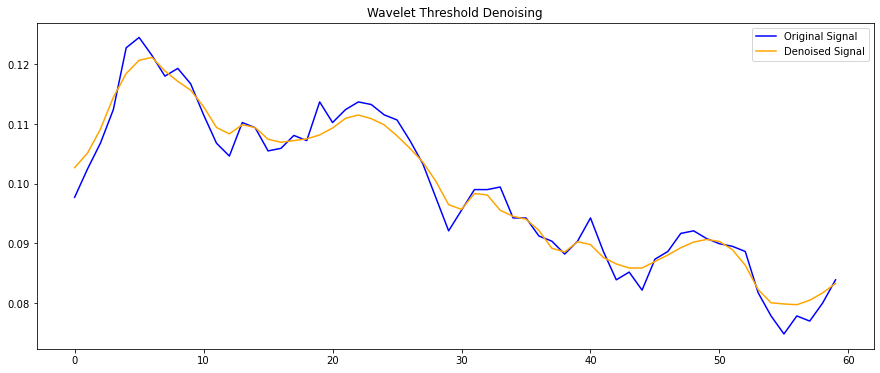

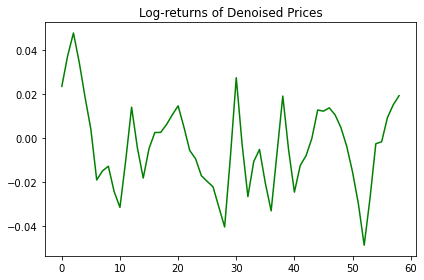

In [45]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Rigrsure threshold method
def rigrsure_thresh(data):
    n = len(data)
    sort_data = np.sort(np.abs(data))
    risk = np.zeros(n)
    for i in range(n):
        lambda_i = sort_data[i]
        term1 = (n - 2 * i) * lambda_i**2
        term2 = np.sum(sort_data[:i]**2)
        risk[i] = term1 + term2
    best_idx = np.argmin(risk)
    return sort_data[best_idx]

# Wavelet denoising
def wavelet_denoise(data, wavelet='db4', mode='soft', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = rigrsure_thresh(coeffs[-1])
    coeffs[1:] = [pywt.threshold(c, threshold, mode=mode) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Simulate noisy data

# data = np.sin(2 * np.pi * np.linspace(0, 1, 128)) + 0.5 * np.random.randn(128)
data = df['features'][5].replace('[', '').replace(']', '').replace('\n', '').split()
data = [float(val) for val in data]

data = np.array(data)
print(data)

denoised_data = wavelet_denoise(data)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(data, color='blue', label='Original Signal')
plt.plot(denoised_data, color='orange', label='Denoised Signal')
plt.legend()
plt.title("Wavelet Threshold Denoising")
plt.show()


# Calculate log-returns
log_returns = np.diff(np.log(denoised_data))
plt.plot(log_returns, color='green')
plt.title('Log-returns of Denoised Prices')
plt.tight_layout()
plt.show()

/Users/rohitgulve/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


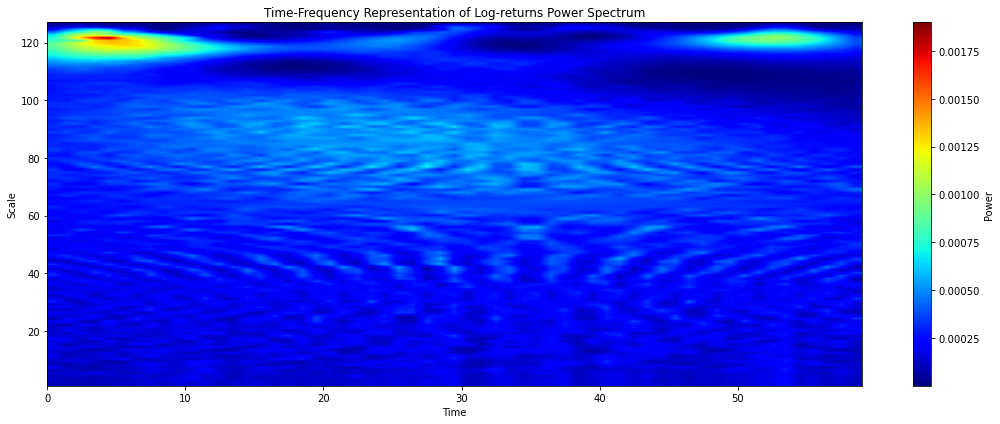

In [46]:
# Compute the continuous wavelet transform (CWT) using Morlet wavelet
widths = np.arange(1, 128)  # arbitrary range of scales
cwtmatr, _ = pywt.cwt(log_returns, widths, 'cmor')

# Compute the power spectrum
power_spectrum = np.abs(cwtmatr)**2

# Visualization
plt.figure(figsize=(15, 6))
plt.imshow(power_spectrum, aspect='auto', extent=[0, len(log_returns), 1, max(widths)], 
           cmap='jet', interpolation='bilinear')
plt.colorbar(label="Power")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title('Time-Frequency Representation of Log-returns Power Spectrum')
plt.tight_layout()
plt.show()